# Análise de maré do modelo Delft3D: vento + maré

In [1]:
import pooch


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_wind.nc4",
    known_hash="sha256:f3c5fd95ccffb9baea40aa431f6e0946cb2f49ea07274083e5d704e8099ea4c6",
)

In [2]:
import cf_xarray
import xarray as xr


ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (time: 9517, m: 138, n: 218)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-01 ... 2022-02-01
Data variables:
    waterlevel  (time, m, n) float32 ...
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Mon Aug 22 14:21:18 2022: ncks -4 -L 1 jan...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.0 (Homepage =...

In [3]:
import xoak


# sklearn_geo_balltree would be better than scipy_kdtree but it doesn't accept NaNsseries
ds.xoak.set_index(["latitude", "longitude"], "scipy_kdtree")

In [4]:
import pandas as pd


df = pd.read_csv("Dados_Mare_Florencio2022.csv", index_col=0)
df

,Lon,Lat,M2,M2_fase,S2,S2_fase,O1,O1_fase,K1,K1_fase,N2,N2_fase,Q1,Q1_fase
ADCP_BaiaNorte,-48.5591,-27.5559,0.26,162.82,0.15,154.62,0.11,121.03,0.09,165.74,NaN,NaN,NaN,NaN
ADCP_BaiaSul,-48.5631,-27.5976,0.25,165.61,0.18,181.28,0.11,126.35,0.08,200.90,0.05,234.84,0.04,79.59
ACDP_Mocambique,-48.3896,-27.5267,0.19,148.12,0.13,135.02,0.03,91.06,0.06,161.89,0.03,219.91,0.03,91.06
Maregrafo_BaiaNorte,-48.4810,-27.4329,0.24,150.20,0.16,153.62,0.11,114.36,0.07,174.80,0.04,223.93,0.03,84.75
Maregrafo_BaiaSul,-48.5639,-27.8160,0.19,163.70,0.14,167.06,0.11,120.50,0.07,182.47,0.04,243.13,0.03,89.96


In [5]:
import numpy as np


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


series = {}
for location, row in df.iterrows():
    m = find_nearest(ds["m"], row["Lon"])
    n = find_nearest(ds["n"], row["Lat"])
    serie = ds.isel(m=m, n=n)
    if np.isnan(serie["longitude"].to_numpy()):
        print(f"Skipping {location}.")
        continue
    series.update({location: serie})

Skipping ADCP_BaiaSul.
Skipping Maregrafo_BaiaSul.


In [6]:
for location, row in df.iterrows():
    if location in ["ADCP_BaiaSul", "Maregrafo_BaiaSul"]:
        point = xr.Dataset({
            "longitude": ("point", [row["Lon"]]),
            "latitude": ("point", [row["Lat"]]),
        })

        print(location)
        model_series = ds.xoak.sel(
            longitude=point["longitude"],
            latitude=point["latitude"],
        )
        series.update({location: model_series})

ADCP_BaiaSul
Maregrafo_BaiaSul


In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def creat_map(projection=ccrs.PlateCarree(), figsize=(4, 4), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.xlines = gl.ylines = False
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [8]:
bbox = ds["m"].min(), ds["m"].max(), ds["n"].min(), ds["n"].max()
bbox = [v.to_numpy() for v in bbox]

In [9]:
import numpy as np


x, y = np.meshgrid(ds["m"], ds["n"])

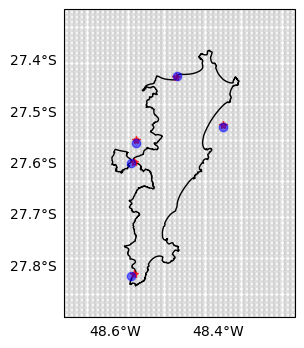

In [10]:
# %matplotlib notebook
import geopandas


gdf = geopandas.read_file("data/floripa.geojson")
geom = gdf["geometry"].squeeze()

fig, ax = creat_map(bbox=bbox)

kw = {"marker": ".", "linestyle": "-", "alpha": 0.25, "color": "darkgray"}
ax.plot(x, y, **kw, zorder=0);
for location, row in df.iterrows():
    ax.plot(row["Lon"], row["Lat"], "r*", label=location, alpha=0.75)

for location, serie in series.items():
    ax.plot(serie["longitude"], serie["latitude"], "bo", alpha=0.55)

ax.set_extent([-48.7, -48.25, -27.9, -27.3])
# Using a custom coastline b/c the global one sucks!
# ax.coastlines(resolution="10m")
ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor="black", facecolor="none");

In [11]:
model_elev = {k: v["waterlevel"].to_numpy().squeeze() for k, v in series.items()}

model_elev = pd.DataFrame(model_elev)
model_elev.index = series["ACDP_Mocambique"]["time"].to_numpy()

In [12]:
import utide


def summary_table(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["A"] = coef["A"]
    summary["A_ci"] = coef["A_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="A", ascending=False)


def harmonics(waterlevel, index, lat):
    coef = utide.solve(
        index,
        waterlevel,
        lat=lat,
        method="robust",
        conf_int="MC",
        verbose=False,
    )
    table = summary_table(coef)
    return table

In [13]:
results = {}

for location, row in df.iterrows():
    serie = model_elev[location]
    index = serie.index 
    waterlevel = serie.to_numpy()
    lat = row["Lat"]
    
    results.update({location: harmonics(waterlevel, index, lat)})

## Comparações

In [14]:
location = "ADCP_BaiaNorte"

df.loc[[location]].drop(["Lon", "Lat"], axis=1)

,M2,M2_fase,S2,S2_fase,O1,O1_fase,K1,K1_fase,N2,N2_fase,Q1,Q1_fase
ADCP_BaiaNorte,0.26,162.82,0.15,154.62,0.11,121.03,0.09,165.74,NaN,NaN,NaN,NaN


In [15]:
results[location].loc[["M2", "S2", "O1", "K1", "Q1"]]

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,52.612036,661406.350825,0.080511,0.276801,0.000667,173.467793,0.183427
S2,23.805062,231505.515450,0.083333,0.186191,0.000758,175.217775,0.205629
O1,8.665506,447331.309175,0.038731,0.112337,0.000329,123.065790,0.209681
K1,2.730877,102433.997024,0.041781,0.063063,0.000386,188.902818,0.305941
Q1,0.599698,21391.665960,0.037219,0.029552,0.000396,96.474984,0.660137


In [16]:
location = "ADCP_BaiaSul"

df.loc[[location]].drop(["Lon", "Lat"], axis=1)

,M2,M2_fase,S2,S2_fase,O1,O1_fase,K1,K1_fase,N2,N2_fase,Q1,Q1_fase
ADCP_BaiaSul,0.25,165.61,0.18,181.28,0.11,126.35,0.08,200.9,0.05,234.84,0.04,79.59


In [17]:
results[location].loc[["M2", "S2", "O1", "K1", "Q1"]]

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,50.144899,216353.595428,0.080511,0.250352,0.001055,182.129884,0.260576
S2,23.157222,87275.574604,0.083333,0.170130,0.001129,184.754901,0.302809
O1,10.072361,330983.044371,0.038731,0.112203,0.000382,127.827046,0.211539
K1,2.980691,116769.693776,0.041781,0.061037,0.000350,194.740008,0.318186
Q1,0.680316,21914.188395,0.037219,0.029160,0.000386,100.264331,0.729332


In [18]:
location = "ACDP_Mocambique"

df.loc[[location]].drop(["Lon", "Lat"], axis=1)

,M2,M2_fase,S2,S2_fase,O1,O1_fase,K1,K1_fase,N2,N2_fase,Q1,Q1_fase
ACDP_Mocambique,0.19,148.12,0.13,135.02,0.03,91.06,0.06,161.89,0.03,219.91,0.03,91.06


In [19]:
results[location].loc[["M2", "S2", "O1", "K1", "Q1"]]

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,45.293281,1.872895e+07,0.080511,0.193247,0.000088,153.177850,0.031623
S2,20.889173,6.043813e+06,0.083333,0.131237,0.000105,151.968468,0.048535
O1,13.750160,4.835596e+05,0.038731,0.106476,0.000300,113.536802,0.193998
K1,4.491165,1.862322e+05,0.041781,0.060852,0.000276,176.962328,0.278494
Q1,0.993561,3.170806e+04,0.037219,0.028622,0.000315,88.543401,0.641648


In [20]:
location = "Maregrafo_BaiaNorte"

df.loc[[location]].drop(["Lon", "Lat"], axis=1)

,M2,M2_fase,S2,S2_fase,O1,O1_fase,K1,K1_fase,N2,N2_fase,Q1,Q1_fase
Maregrafo_BaiaNorte,0.24,150.2,0.16,153.62,0.11,114.36,0.07,174.8,0.04,223.93,0.03,84.75


In [21]:
results[location].loc[["M2", "S2", "O1", "K1", "Q1"]]

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,51.180796,7.586326e+06,0.080511,0.236925,0.000169,153.572363,0.043502
S2,22.763358,2.847186e+06,0.083333,0.158007,0.000184,153.236104,0.058019
O1,10.708256,3.365959e+05,0.038731,0.108372,0.000366,114.008262,0.206844
K1,3.540358,1.166443e+05,0.041781,0.062313,0.000358,177.784632,0.380987
Q1,0.759296,1.683793e+04,0.037219,0.028858,0.000436,88.733974,0.733331


In [22]:
location = "Maregrafo_BaiaSul"

df.loc[[location]].drop(["Lon", "Lat"], axis=1)

,M2,M2_fase,S2,S2_fase,O1,O1_fase,K1,K1_fase,N2,N2_fase,Q1,Q1_fase
Maregrafo_BaiaSul,0.19,163.7,0.14,167.06,0.11,120.5,0.07,182.47,0.04,243.13,0.03,89.96


In [23]:
results[location].loc[["M2", "S2", "O1", "K1", "Q1"]]

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,41.932484,2.441967e+06,0.080511,0.177245,0.000222,162.378957,0.085686
S2,20.694696,7.527898e+05,0.083333,0.124517,0.000281,161.808556,0.129172
O1,15.503566,5.862569e+05,0.038731,0.107774,0.000276,116.628709,0.196804
K1,4.987425,1.403964e+05,0.041781,0.061127,0.000320,181.039285,0.323210
Q1,1.098901,2.471490e+04,0.037219,0.028693,0.000358,90.470002,0.581092
